# Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto

***
## Part 1 : Importing the data from the Wikipedia page

In [161]:
import requests
import pandas as pd
from bs4 import BeautifulSoup


# Getting the table from Wikipedia

url = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text
soup = BeautifulSoup(url, 'lxml')
table = soup.find('table')

table_data = []

for cell in table.find_all('p'):
    postal_code = cell.find('b').get_text()
    for body in cell.find_all('span'):
        string = body.get_text()
        borough = string.split("(")[0]
        neighborhood = "Not assigned"
        if borough != "Not assigned":
            if string.split("(")[1] != None:
                neighborhood = string.split("(")[1].replace(" /",",")[:-1].replace(')',' ')
            else:
                neighborhood = borough
            table_data.append([postal_code, borough, neighborhood])

df = pd.DataFrame(table_data, columns=['PostalCode','Borough','Neighborhood'])

df.head(15)


,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills Nort
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [162]:
df.shape

(103, 3)

***
## Part 2 : Getting the coordinates for each postcode

The <i>Geocoder Python package</i> does not seem to work on my side, so I will use the provided .csv file.

In [163]:
# Creating a dataframe from the .csv file
url = 'https://github.com/pajivoult/Coursera_Capstone/blob/cc3a7069dd2acc971935d6f26b44325d60949562/Geospatial_Coordinates.csv?raw=true'
coordinates = pd.read_csv(url)
coordinates.rename(columns={"Postal Code":"PostalCode"},inplace=True)

# Merging the two tables
table_coord = pd.merge(df,coordinates,on=['PostalCode'])
table_coord

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East TorontoBusiness reply mail Processing Cen...,Enclave of M4L,43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


***
## Part 3 : Exploring the Data and clustering

In [164]:
### Boroughs containing 'Toronto'
#df_toronto = table_coord[table_coord['Borough'].str.contains('Toronto')]


### All Boroughs
# we could have used only the Boroughs that have 'Toronto' in their name but it's probably more interesting to analyse all of them

df_toronto = table_coord

df_toronto.shape

(103, 5)

In [165]:
CLIENT_ID = '#########' # your Foursquare ID
CLIENT_SECRET = '#########' # your Foursquare Secret
ACCESS_TOKEN = '#########' # your FourSquare Access Token
VERSION = '#########'
LIMIT = 100

In [166]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [222]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude']
                                  )

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Ontario Provincial Government
Islington Avenue
Malvern, Rouge
Don Mills Nort
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills Sout
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
The Danforth  East
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmount Park
Bayview Village
Downsview East 
The Danforth 

In [226]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [260]:
import numpy as np

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Breakfast Spot,Latin American Restaurant,Skating Rink,Event Space,Falafel Restaurant,Ethiopian Restaurant,Escape Room,Discount Store,Electronics Store
1,"Alderwood, Long Branch",Pizza Place,Playground,Sandwich Place,Pub,Coffee Shop,Skating Rink,Gym,Pharmacy,Dumpling Restaurant,Drugstore
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Ice Cream Shop,Frozen Yogurt Shop,Shopping Mall,Sandwich Place,Diner,Middle Eastern Restaurant,Restaurant,Supermarket
3,Bayview Village,Café,Japanese Restaurant,Chinese Restaurant,Bank,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Yoga Studio
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Sandwich Place,Coffee Shop,Pizza Place,Pharmacy,Restaurant,Sushi Restaurant,Pub,Café,Butcher


In [256]:
# Defining a function that will tell us which k value we should choose in order to get the smallest "big cluster"
# Indeed, with k<7 we would get a cluster that gathers more than 75% of the venues, so that wouldn't be too meaningful...

from sklearn.cluster import KMeans

def biggest_cluster(kclusters):
    toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
    toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']
    toronto_grouped = toronto_onehot.groupby('Neighborhood',axis=0).mean().reset_index()
    toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

    # check cluster labels generated for each row in the dataframe
    #kmeans.labels_[0:39] 

    toronto_grouped.insert(0, 'Cluster Labels', kmeans.labels_)

    toronto_merged = pd.merge(df_toronto,toronto_grouped[['Neighborhood','Cluster Labels']],on='Neighborhood')

    return toronto_merged.groupby('Cluster Labels').count()['PostalCode'].max()

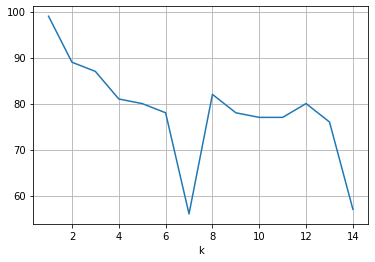

In [257]:
k_vs_biggest_cluster = []
for i in range(1,15):
    k_vs_biggest_cluster.append([i, biggest_cluster(i)])

df_k_cluster = pd.DataFrame(k_vs_biggest_cluster, columns=['k','Size of biggest cluster'])
df_k_cluster.set_index('k',inplace=True)
df_k_cluster['Size of biggest cluster'].plot(grid=True)


In [258]:
best_k = df_k_cluster.loc[df_k_cluster['Size of biggest cluster'] == df_k_cluster['Size of biggest cluster'].min()].index.to_numpy()[0]
best_k

7

In [261]:
# Resetting the values...
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood']
toronto_grouped = toronto_onehot.groupby('Neighborhood',axis=0).mean().reset_index()


from sklearn.cluster import KMeans

# setting best number of clusters
kclusters = best_k

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
neighborhoods_venues_sorted.head()
toronto_merged = pd.merge(df_toronto[['Neighborhood','Latitude','Longitude']],neighborhoods_venues_sorted,on='Neighborhood')

toronto_merged.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Parkwoods,43.753259,-79.329656,2,Food & Drink Shop,Park,Pool,Yoga Studio,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
1,Victoria Village,43.725882,-79.315572,0,Pizza Place,Portuguese Restaurant,Intersection,Hockey Arena,Coffee Shop,Eastern European Restaurant,Dumpling Restaurant,Electronics Store,Escape Room,Ethiopian Restaurant
2,"Regent Park, Harbourfront",43.654260,-79.360636,2,Coffee Shop,Park,Pub,Bakery,Breakfast Spot,Theater,Café,Yoga Studio,Shoe Store,French Restaurant
3,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,2,Clothing Store,Furniture / Home Store,Accessories Store,Boutique,Gift Shop,Coffee Shop,Women's Store,Vietnamese Restaurant,Airport Service,Distribution Center
4,Ontario Provincial Government,43.662301,-79.389494,0,Coffee Shop,Sushi Restaurant,College Cafeteria,Yoga Studio,Sandwich Place,Japanese Restaurant,Mexican Restaurant,Bar,Bank,Diner


In [262]:
import folium
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as colors

latitude = 43.72
longitude = -79.40

# creating a map of Toronto using latitude and longitude values
map_clusters_Toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# setting color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# adding markers to map
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighborhood'],toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_Toronto)
    
map_clusters_Toronto

In [263]:
# Checking the size of each cluster

toronto_merged.groupby('Cluster Labels').count()[["Neighborhood"]]

,Neighborhood
Cluster Labels,
0,29
1,1
2,56
3,2
4,1
5,2
6,8


In [264]:
#For each cluster, getting the defining characteristics (i.e. most common value for each column)

toronto_merged.groupby('Cluster Labels').agg(lambda x:x.value_counts().index[0]).iloc[:,3:13]

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Cluster Labels,,,,,,,,,,
0,Pizza Place,Sandwich Place,Coffee Shop,Pharmacy,Coffee Shop,Drugstore,Restaurant,Dog Run,Doner Restaurant,Donut Shop
1,Filipino Restaurant,Yoga Studio,Dumpling Restaurant,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant
2,Coffee Shop,Café,Coffee Shop,Café,Yoga Studio,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Doner Restaurant
3,Baseball Field,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Fast Food Restaurant
4,Bar,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Eastern European Restaurant,Fast Food Restaurant
5,Fast Food Restaurant,Dim Sum Restaurant,Falafel Restaurant,Concert Hall,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Dumpling Restaurant,Electronics Store
6,Park,Convenience Store,Yoga Studio,Dumpling Restaurant,Distribution Center,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Electronics Store
